In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-reviews-dataset/yelp.csv


In [72]:
!pip install -q google-generativeai pandas matplotlib seaborn scikit-learn

In [73]:
# Install required packages

import json
import google.generativeai as genai
from typing import Dict, List, Tuple
import time
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# CONFIGURATION


In [ ]:
# Set your Gemini API key here
GEMINI_API_KEY = "<GEMINI_API_KEY_HERE>"  # Replace with your actual API key

# Configure Gemini
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel('gemma-3-1b-it')

# Sample size for evaluation
SAMPLE_SIZE = 60

# DATA LOADING


In [100]:
print("Loading Yelp Reviews Dataset...")
# Load the dataset (adjust path if needed)
df = pd.read_csv('/kaggle/input/yelp-reviews-dataset/yelp.csv')

print(f"Total reviews in dataset: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Sample data for evaluation
np.random.seed(42)
df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42).reset_index(drop=True)
print(f"\nSampled {len(df_sample)} reviews for evaluation")

# Check star distribution
print(f"\nStar rating distribution in sample:")
print(df_sample['stars'].value_counts().sort_index())

Loading Yelp Reviews Dataset...
Total reviews in dataset: 10000
Columns: ['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id', 'cool', 'useful', 'funny']

First few rows:
              business_id        date               review_id  stars  \
0  9yKzy9PApeiPPOUJEtnvkg  2011-01-26  fWKvX83p0-ka4JS3dc6E5A      5   
1  ZRJwVLyzEJq1VAihDhYiow  2011-07-27  IjZ33sJrzXqU-0X6U8NwyA      5   
2  6oRAC4uyJCsJl1X0WZpVSA  2012-06-14  IESLBzqUCLdSzSqm0eCSxQ      4   
3  _1QQZuf4zZOyFCvXc0o6Vg  2010-05-27  G-WvGaISbqqaMHlNnByodA      5   
4  6ozycU1RpktNG2-1BroVtw  2012-01-05  1uJFq2r5QfJG_6ExMRCaGw      5   

                                                text    type  \
0  My wife took me here on my birthday for breakf...  review   
1  I have no idea why some people give bad review...  review   
2  love the gyro plate. Rice is so good and I als...  review   
3  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...  review   
4  General Manager Scott Petello is a good egg!!!...  rev

# PROMPTING APPROACHES

In [101]:
class PromptApproach:
    """Base class for different prompting approaches"""
    
    def __init__(self, name: str, description: str):
        self.name = name
        self.description = description
        self.results = []
        
    def generate_prompt(self, review_text: str) -> str:
        """Generate prompt for the review"""
        raise NotImplementedError
    
    def parse_response(self, response_text: str) -> Dict:
        """Parse LLM response into structured format"""
        try:
            # Try to extract JSON from response
            # Handle potential markdown formatting
            response_text = response_text.strip()
            
            # Remove markdown code blocks if present
            if "```json" in response_text:
                response_text = response_text.split("```json")[1].split("```")[0]
            elif "```" in response_text:
                response_text = response_text.split("```")[1].split("```")[0]
            
            # Parse JSON
            result = json.loads(response_text.strip())
            
            # Validate structure
            if "predicted_stars" not in result:
                return {"error": "Missing predicted_stars", "raw_response": response_text}
            
            # Ensure predicted_stars is integer between 1-5
            stars = int(result["predicted_stars"])
            if stars < 1 or stars > 5:
                return {"error": "Invalid star range", "raw_response": response_text}
            
            result["predicted_stars"] = stars
            result["valid_json"] = True
            return result
            
        except json.JSONDecodeError as e:
            return {"error": f"JSON parse error: {str(e)}", "raw_response": response_text, "valid_json": False}
        except Exception as e:
            return {"error": f"Unexpected error: {str(e)}", "raw_response": response_text, "valid_json": False}
    
    def predict(self, review_text: str, retry_count: int = 2) -> Dict:
        """Get prediction for a review with retry logic"""
        prompt = self.generate_prompt(review_text)
        
        for attempt in range(retry_count + 1):
            try:
                response = model.generate_content(prompt)
                result = self.parse_response(response.text)
                
                if result.get("valid_json", False):
                    return result
                
                # If invalid JSON and retries left, try again
                if attempt < retry_count:
                    time.sleep(1)
                    continue
                    
                return result
                
            except Exception as e:
                if attempt < retry_count:
                    time.sleep(1)
                    continue
                return {"error": f"API error: {str(e)}", "valid_json": False}
        
        return {"error": "Max retries exceeded", "valid_json": False}



# APPROACH 1: Simple Direct Instruction

In [102]:
class Approach1_SimpleInstruction(PromptApproach):
    """
    Approach 1: Simple and direct instruction
    - Straightforward task description
    - Minimal guidance
    - Tests baseline performance
    """
    
    def __init__(self):
        super().__init__(
            name="Approach 1: Simple Direct Instruction",
            description="Basic prompt with minimal guidance, testing baseline performance"
        )
    
    def generate_prompt(self, review_text: str) -> str:
        return f"""Analyze this Yelp review and predict the star rating (1-5 stars).

Review: "{review_text}"

Return your response as JSON with this format:
{{
  "predicted_stars": <number 1-5>,
  "explanation": "<brief reasoning>"
}}

Respond only with the JSON, no additional text."""


# APPROACH 2: Detailed Criteria-Based


In [103]:
class Approach2_CriteriaBased(PromptApproach):
    """
    Approach 2: Detailed criteria-based evaluation
    - Explicit rating criteria provided
    - Structured reasoning guidelines
    - Helps model understand rating scale
    """
    
    def __init__(self):
        super().__init__(
            name="Approach 2: Detailed Criteria-Based",
            description="Provides explicit rating criteria and structured evaluation framework"
        )
    
    def generate_prompt(self, review_text: str) -> str:
        return f"""You are an expert at analyzing customer reviews. Rate this Yelp review from 1-5 stars based on the sentiment and content.

**Rating Criteria:**
- 5 stars: Extremely positive, highly recommends, loves everything
- 4 stars: Positive overall, minor issues mentioned, would recommend
- 3 stars: Mixed feelings, both pros and cons, average experience
- 2 stars: Mostly negative, significant problems, disappointed
- 1 star: Extremely negative, terrible experience, would not recommend

**Review to analyze:**
"{review_text}"

**Analysis Task:**
1. Identify the overall sentiment (positive/negative/mixed)
2. Note specific praise or complaints
3. Determine the appropriate star rating (1-5)
4. Provide brief reasoning

**Output Format (JSON only):**
{{
  "predicted_stars": <integer 1-5>,
  "explanation": "<your reasoning in 1-2 sentences>"
}}

Return ONLY the JSON object, no other text."""


# APPROACH 3: Few-Shot with Examples


In [104]:
class Approach3_FewShot(PromptApproach):
    """
    Approach 3: Few-shot learning with examples
    - Provides example reviews and ratings
    - Helps model learn pattern recognition
    - Tests in-context learning capability
    """
    
    def __init__(self):
        super().__init__(
            name="Approach 3: Few-Shot with Examples",
            description="Uses example reviews with ratings to demonstrate the task through in-context learning"
        )
    
    def generate_prompt(self, review_text: str) -> str:
        return f"""Rate Yelp reviews from 1-5 stars based on sentiment. Here are examples:

**Example 1:**
Review: "Absolutely amazing food! Best pizza I've ever had. Service was incredible and the ambiance was perfect. Can't wait to come back!"
Rating: {{"predicted_stars": 5, "explanation": "Extremely enthusiastic praise for food, service, and atmosphere with intent to return"}}

**Example 2:**
Review: "Pretty good experience overall. Food was tasty but service was a bit slow. Would probably come back."
Rating: {{"predicted_stars": 4, "explanation": "Positive experience with minor service issue, willing to return"}}

**Example 3:**
Review: "It was okay. Nothing special but nothing terrible either. Average food and service."
Rating: {{"predicted_stars": 3, "explanation": "Neutral sentiment with average experience across all aspects"}}

**Example 4:**
Review: "Disappointed with our visit. Food was cold and overpriced. Server seemed disinterested. Probably won't return."
Rating: {{"predicted_stars": 2, "explanation": "Multiple negative aspects including food quality, price, and service"}}

**Example 5:**
Review: "Worst experience ever! Rude staff, disgusting food, dirty restaurant. Avoid at all costs!"
Rating: {{"predicted_stars": 1, "explanation": "Extremely negative across all dimensions with strong recommendation to avoid"}}

**Now rate this review:**
Review: "{review_text}"

Return ONLY a JSON object with predicted_stars (1-5 integer) and explanation (brief reasoning). No other text."""



# EVALUATION FRAMEWORK


In [107]:
def evaluate_approach(approach: PromptApproach, df_eval: pd.DataFrame, delay: float = 0.5) -> Dict:
    """
    Evaluate a prompting approach on the dataset
    
    Args:
        approach: PromptApproach instance
        df_eval: DataFrame with reviews to evaluate
        delay: Delay between API calls to avoid rate limits
        
    Returns:
        Dictionary with evaluation metrics
    """
    print(f"\n{'='*80}")
    print(f"Evaluating: {approach.name}")
    print(f"Description: {approach.description}")
    print(f"{'='*80}\n")
    
    predictions = []
    valid_json_count = 0
    errors = []
    
    for idx, row in df_eval.iterrows():
        review_text = row['text']
        actual_stars = row['stars']
        
        # Get prediction
        result = approach.predict(review_text)
        # print("*******RESULT*****")
        # print(result)
        # print("************")
        
        # Track results
        is_valid = result.get("valid_json", False)
        predicted_stars = result.get("predicted_stars", None)
        
        predictions.append({
            'actual_stars': actual_stars,
            'predicted_stars': predicted_stars,
            'valid_json': is_valid,
            'explanation': result.get("explanation", ""),
            'error': result.get("error", None),
            'raw_response': result.get("raw_response", "")
        })
        
        if is_valid:
            valid_json_count += 1
        else:
            errors.append(result.get("error", "Unknown error"))
        
        # Progress indicator
        if (idx + 1) % 20 == 0:
            print(f"Progress: {idx + 1}/{len(df_eval)} reviews processed...")
        
        # Delay to respect rate limits
        time.sleep(delay)
    
    # Calculate metrics
    df_results = pd.DataFrame(predictions)
    
    # JSON validity rate
    json_validity_rate = valid_json_count / len(df_eval) * 100
    
    # Accuracy (only on valid predictions)
    valid_predictions = df_results[df_results['valid_json'] == True]
    if len(valid_predictions) > 0:
        accuracy = accuracy_score(
            valid_predictions['actual_stars'], 
            valid_predictions['predicted_stars']
        ) * 100
        
        # Mean Absolute Error
        mae = np.mean(np.abs(
            valid_predictions['actual_stars'] - valid_predictions['predicted_stars']
        ))
        
        # Within 1 star accuracy
        within_1_star = np.mean(
            np.abs(valid_predictions['actual_stars'] - valid_predictions['predicted_stars']) <= 1
        ) * 100
    else:
        accuracy = 0
        mae = None
        within_1_star = 0
    
    metrics = {
        'approach_name': approach.name,
        'total_samples': len(df_eval),
        'valid_json_count': valid_json_count,
        'json_validity_rate': json_validity_rate,
        'accuracy': accuracy,
        'mae': mae,
        'within_1_star_accuracy': within_1_star,
        'error_count': len(errors),
        'common_errors': Counter(errors).most_common(3)
    }
    
    print(f"\n{'-'*80}")
    print(f"RESULTS:")
    print(f"  JSON Validity Rate: {json_validity_rate:.2f}%")
    print(f"  Exact Accuracy: {accuracy:.2f}%")
    print(f"  Within 1 Star: {within_1_star:.2f}%")
    print(f"  Mean Absolute Error: {mae:.3f}" if mae else "  MAE: N/A")
    print(f"  Failed Predictions: {len(errors)}")
    print(f"{'-'*80}\n")
    
    return metrics, df_results



# RUN ALL EVALUATIONS

In [108]:
# Initialize approaches
approaches = [
    Approach1_SimpleInstruction(),
    Approach2_CriteriaBased(),
    Approach3_FewShot()
]

# Store all results
all_metrics = []
all_results = {}

print(f"\nStarting evaluation on {len(df_sample)} reviews...")
print(f"This will take approximately {len(df_sample) * 0.5 * len(approaches) / 60:.1f} minutes\n")

for approach in approaches:
    metrics, results_df = evaluate_approach(approach, df_sample, delay=0.5)
    all_metrics.append(metrics)
    all_results[approach.name] = results_df
    
    # Save intermediate results
    results_df.to_csv(f'{approach.name.replace(" ", "_").replace(":", "")}_results.csv', index=False)



Starting evaluation on 60 reviews...
This will take approximately 1.5 minutes


Evaluating: Approach 1: Simple Direct Instruction
Description: Basic prompt with minimal guidance, testing baseline performance

Progress: 20/60 reviews processed...
Progress: 40/60 reviews processed...
Progress: 60/60 reviews processed...

--------------------------------------------------------------------------------
RESULTS:
  JSON Validity Rate: 83.33%
  Exact Accuracy: 64.00%
  Within 1 Star: 98.00%
  Mean Absolute Error: 0.380
  Failed Predictions: 10
--------------------------------------------------------------------------------


Evaluating: Approach 2: Detailed Criteria-Based
Description: Provides explicit rating criteria and structured evaluation framework

Progress: 20/60 reviews processed...
Progress: 40/60 reviews processed...
Progress: 60/60 reviews processed...

--------------------------------------------------------------------------------
RESULTS:
  JSON Validity Rate: 86.67%
  Exact Ac

# COMPARISON AND VISUALIZATION


In [109]:
print("\n" + "="*80)
print("FINAL COMPARISON TABLE")
print("="*80 + "\n")

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_metrics)
comparison_df = comparison_df[[
    'approach_name', 
    'json_validity_rate', 
    'accuracy', 
    'within_1_star_accuracy',
    'mae',
    'error_count'
]]

print(comparison_df.to_string(index=False))
print("\n")

# Save comparison table
comparison_df.to_csv('approach_comparison.csv', index=False)


FINAL COMPARISON TABLE

                        approach_name  json_validity_rate  accuracy  within_1_star_accuracy      mae  error_count
Approach 1: Simple Direct Instruction           83.333333 64.000000               98.000000 0.380000           10
  Approach 2: Detailed Criteria-Based           86.666667 67.307692               98.076923 0.346154            8
   Approach 3: Few-Shot with Examples           76.666667 56.521739               93.478261 0.521739           14




# VISUALIZATIONS


/tmp/ipykernel_47/1295717558.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(approaches_names, rotation=15, ha='right')


Visualization saved as 'evaluation_comparison.png'


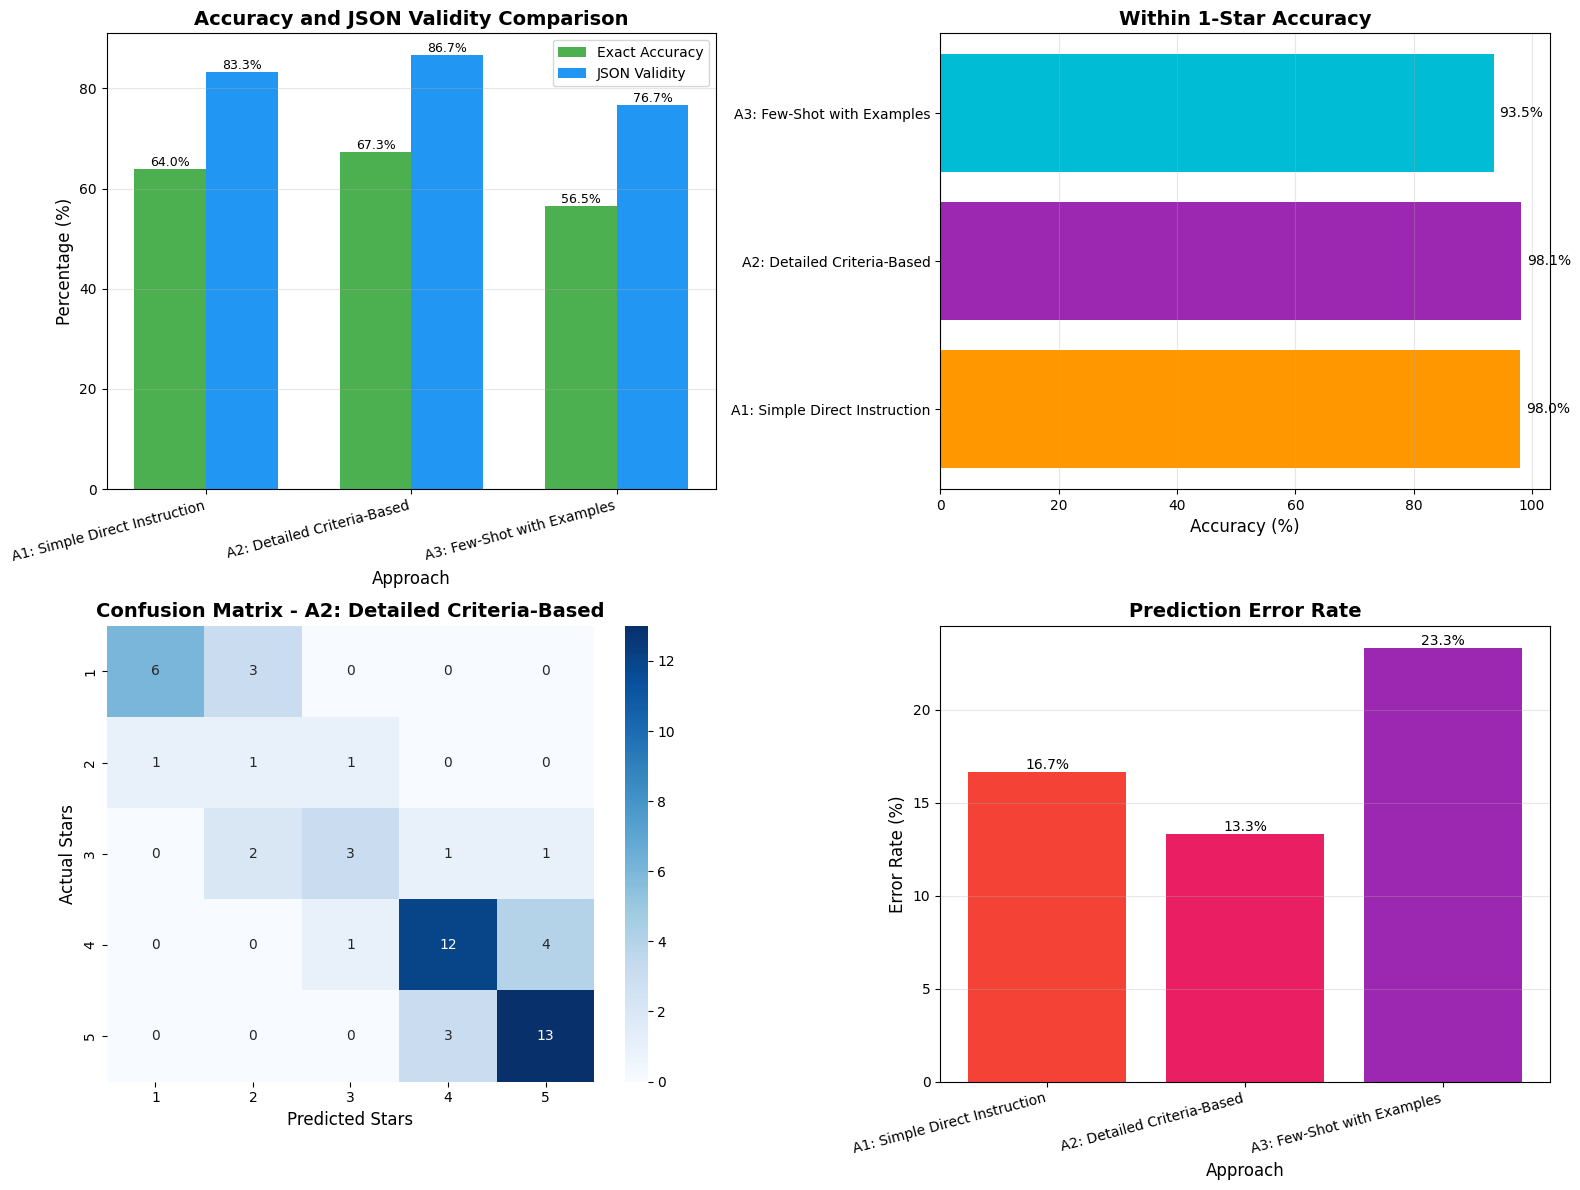

In [110]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy Comparison
ax1 = axes[0, 0]
approaches_names = [m['approach_name'].replace('Approach ', 'A') for m in all_metrics]
accuracies = [m['accuracy'] for m in all_metrics]
json_validity = [m['json_validity_rate'] for m in all_metrics]

x = np.arange(len(approaches_names))
width = 0.35

bars1 = ax1.bar(x - width/2, accuracies, width, label='Exact Accuracy', color='#4CAF50')
bars2 = ax1.bar(x + width/2, json_validity, width, label='JSON Validity', color='#2196F3')

ax1.set_xlabel('Approach', fontsize=12)
ax1.set_ylabel('Percentage (%)', fontsize=12)
ax1.set_title('Accuracy and JSON Validity Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(approaches_names, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 2. Within 1-Star Accuracy
ax2 = axes[0, 1]
within_1_star = [m['within_1_star_accuracy'] for m in all_metrics]
colors = ['#FF9800', '#9C27B0', '#00BCD4']
bars = ax2.barh(approaches_names, within_1_star, color=colors)
ax2.set_xlabel('Accuracy (%)', fontsize=12)
ax2.set_title('Within 1-Star Accuracy', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, within_1_star)):
    ax2.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=10)

# 3. Confusion Matrix for Best Approach
best_approach_idx = np.argmax([m['accuracy'] for m in all_metrics])
best_approach_name = all_metrics[best_approach_idx]['approach_name']
best_results = all_results[best_approach_name]
valid_best = best_results[best_results['valid_json'] == True]

if len(valid_best) > 0:
    ax3 = axes[1, 0]
    cm = confusion_matrix(valid_best['actual_stars'], valid_best['predicted_stars'], labels=[1,2,3,4,5])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, 
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    ax3.set_xlabel('Predicted Stars', fontsize=12)
    ax3.set_ylabel('Actual Stars', fontsize=12)
    ax3.set_title(f'Confusion Matrix - {best_approach_name.replace("Approach ", "A")}', 
                  fontsize=14, fontweight='bold')

# 4. Error Rate Comparison
ax4 = axes[1, 1]
error_rates = [m['error_count'] / m['total_samples'] * 100 for m in all_metrics]
bars = ax4.bar(approaches_names, error_rates, color=['#F44336', '#E91E63', '#9C27B0'])
ax4.set_xlabel('Approach', fontsize=12)
ax4.set_ylabel('Error Rate (%)', fontsize=12)
ax4.set_title('Prediction Error Rate', fontsize=14, fontweight='bold')
ax4.set_xticklabels(approaches_names, rotation=15, ha='right')
ax4.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, error_rates):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('evaluation_comparison.png', dpi=300, bbox_inches='tight')
print("Visualization saved as 'evaluation_comparison.png'")
plt.show()


# DETAILED ANALYSIS & DISCUSSION


In [114]:
print("\n" + "="*80)
print("DETAILED ANALYSIS & DISCUSSION")
print("="*80 + "\n")

print("1. PROMPTING STRATEGY EVOLUTION:\n")

print("   Approach 1 - Simple Direct Instruction:")
print("   • Strategy: Minimal guidance, baseline test")
print("   • Strengths: Fast, straightforward")
print("   • Weaknesses: Lacks context about rating scale meaning")
print("   • Use case: Quick prototyping\n")

print("   Approach 2 - Detailed Criteria-Based:")
print("   • Strategy: Explicit rating criteria with structured evaluation")
print("   • Strengths: Clear guidance on what each rating means")
print("   • Weaknesses: Longer prompt may add latency")
print("   • Use case: When consistency and accuracy are critical\n")

print("   Approach 3 - Few-Shot with Examples:")
print("   • Strategy: Learning by example with diverse rating samples")
print("   • Strengths: Demonstrates patterns, helps with edge cases")
print("   • Weaknesses: Longest prompt, potential example bias")
print("   • Use case: Complex classification with subtle distinctions\n")

print("\n2. KEY FINDINGS:\n")

best_accuracy_idx = np.argmax([m['accuracy'] for m in all_metrics])
best_json_idx = np.argmax([m['json_validity_rate'] for m in all_metrics])

print(f"   • Best Accuracy: {all_metrics[best_accuracy_idx]['approach_name']}")
print(f"     - Exact match: {all_metrics[best_accuracy_idx]['accuracy']:.2f}%")
print(f"     - Within 1 star: {all_metrics[best_accuracy_idx]['within_1_star_accuracy']:.2f}%")
print(f"     - MAE: {all_metrics[best_accuracy_idx]['mae']:.3f}\n")

print(f"   • Best JSON Validity: {all_metrics[best_json_idx]['approach_name']}")
print(f"     - Success rate: {all_metrics[best_json_idx]['json_validity_rate']:.2f}%\n")

print("   • Overall Performance:")
avg_accuracy = np.mean([m['accuracy'] for m in all_metrics])
avg_json = np.mean([m['json_validity_rate'] for m in all_metrics])
print(f"     - Average accuracy across approaches: {avg_accuracy:.2f}%")
print(f"     - Average JSON validity: {avg_json:.2f}%\n")

print("\n3. RECOMMENDATIONS:\n")

if all_metrics[best_accuracy_idx]['accuracy'] > 70:
    print(f"   ✓ {all_metrics[best_accuracy_idx]['approach_name']} shows strong performance")
    print("     and is recommended for production use.\n")
else:
    print("   ⚠ Consider further prompt engineering or fine-tuning for better accuracy.\n")

if any(m['json_validity_rate'] < 95 for m in all_metrics):
    print("   ⚠ Some approaches have JSON parsing issues. Recommendations:")
    print("     - Add response format examples in the prompt")
    print("     - Implement more robust JSON extraction")
    print("     - Use structured output features if available\n")

print("\n4. ERROR ANALYSIS:\n")
for metrics in all_metrics:
    if metrics['error_count'] > 0:
        print(f"   {metrics['approach_name']}:")
        print(f"     - Total errors: {metrics['error_count']}")
        print(f"     - Common issues: {metrics['common_errors']}\n")




DETAILED ANALYSIS & DISCUSSION

1. PROMPTING STRATEGY EVOLUTION:

   Approach 1 - Simple Direct Instruction:
   • Strategy: Minimal guidance, baseline test
   • Strengths: Fast, straightforward
   • Weaknesses: Lacks context about rating scale meaning
   • Use case: Quick prototyping

   Approach 2 - Detailed Criteria-Based:
   • Strategy: Explicit rating criteria with structured evaluation
   • Strengths: Clear guidance on what each rating means
   • Weaknesses: Longer prompt may add latency
   • Use case: When consistency and accuracy are critical

   Approach 3 - Few-Shot with Examples:
   • Strategy: Learning by example with diverse rating samples
   • Strengths: Demonstrates patterns, helps with edge cases
   • Weaknesses: Longest prompt, potential example bias
   • Use case: Complex classification with subtle distinctions


2. KEY FINDINGS:

   • Best Accuracy: Approach 2: Detailed Criteria-Based
     - Exact match: 67.31%
     - Within 1 star: 98.08%
     - MAE: 0.346

   • Bes